# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

# Load Attributes
Attributes_Leves = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
Attributes_Values =  pd.read_excel('DIAS Attributes - Values 2017.xlsx')


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data analysis

In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [5]:
np.setdiff1d(customers.columns,azdias.columns)

array(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype=object)

In [6]:
print("Azdais data size:", azdias.shape)
print("Customers data size:", customers.shape)

Azdais data size: (891221, 366)
Customers data size: (191652, 369)


In [7]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [8]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [9]:
# Validation of NaN in the variables
print("Columns in Azidas have NaN",(azdias.isna().sum()>0).sum())
print("Columns in Customers have NaN",(customers.isna().sum()>0).sum())

Columns in Azidas have NaN 273
Columns in Customers have NaN 273


In [10]:
#Percent NaN in the variables
porc_nan_azidas = azdias.isna().sum()/azdias.shape[0]
porc_nan_customers = customers.isna().sum()/customers.shape[0]

In [11]:
type(porc_nan_azidas)
data1 = [i for i in porc_nan_azidas]
type(porc_nan_customers)
data2 = [i for i in porc_nan_customers]

6 6


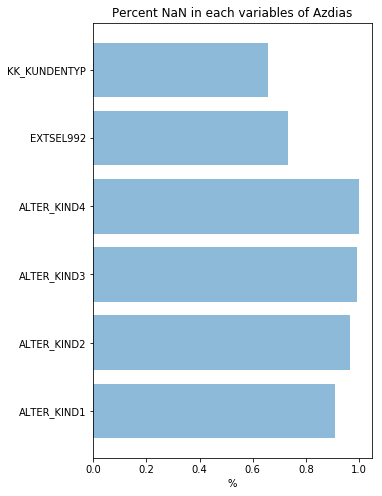

In [12]:
col = azdias.columns
col_names_a = [col[i] for i in range(len(porc_nan_azidas)) if porc_nan_azidas[i]>=0.5 ]
data3 = [i for i in porc_nan_azidas if i >=0.5]
y_pos = np.arange(len(col_names_a))
print(len(data3), len(y_pos))
f, ax = plt.subplots(figsize=(5,8))
plt.barh(y_pos, data3, align='center', alpha=0.5)
plt.yticks(y_pos, col_names_a)
plt.xlabel('%')
plt.title('Percent NaN in each variables of Azdias')
fig = plt.figure(figsize=(20,10))
plt.show()

5 5


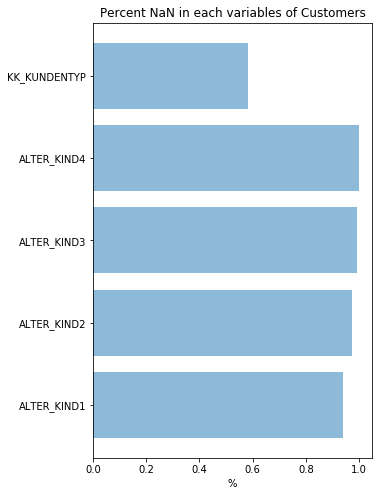

In [13]:
col = customers.columns
col_names_c = [col[i] for i in range(len(porc_nan_customers)) if porc_nan_customers[i]>=0.5 ]
data3 = [i for i in porc_nan_customers if i >=0.5]
y_pos = np.arange(len(col_names_c))
print(len(data3), len(y_pos))
f, ax = plt.subplots(figsize=(5,8))
plt.barh(y_pos, data3, align='center', alpha=0.5)
plt.yticks(y_pos, col_names_c)
plt.xlabel('%')
plt.title('Percent NaN in each variables of Customers')
fig = plt.figure(figsize=(20,10))
plt.show()

## Random samples with their replacement in the database and test set

In [14]:
# Random extraction of each dataset
Azdias_subset = azdias.sample(n = 200000, replace = True)
Customers_subset = customers.sample(n = 43000, replace = True )

In [15]:
# Variables are validated to know if they are in the General Population dataset or in the Customer dataset.
Azdias_subset['Cust_Ind'] = 'General'
Customers_subset['Cust_Ind'] = 'Customer'

print ("General population records from the Azdias data set sample:",Azdias_subset['Cust_Ind'].value_counts())
print ("Customer population from the Customers data set sample:",Customers_subset['Cust_Ind'].value_counts())

General population records from the Azdias data set sample: General    200000
Name: Cust_Ind, dtype: int64
Customer population from the Customers data set sample: Customer    43000
Name: Cust_Ind, dtype: int64


In [16]:
print("CUSTOMER_GROUP:",Customers_subset['CUSTOMER_GROUP'].value_counts())
print("PRODUCT_GROUP:",Customers_subset['PRODUCT_GROUP'].value_counts())
print("ONLINE_PURCHASE:",Customers_subset['ONLINE_PURCHASE'].value_counts())

CUSTOMER_GROUP: MULTI_BUYER     29676
SINGLE_BUYER    13324
Name: CUSTOMER_GROUP, dtype: int64
PRODUCT_GROUP: COSMETIC_AND_FOOD    22630
FOOD                 10608
COSMETIC              9762
Name: PRODUCT_GROUP, dtype: int64
ONLINE_PURCHASE: 0    39162
1     3838
Name: ONLINE_PURCHASE, dtype: int64


In [17]:
df_agg = pd.concat([Azdias_subset, Customers_subset], sort=False)
df_agg['Cust_Ind'].value_counts()

General     200000
Customer     43000
Name: Cust_Ind, dtype: int64

## Analysis

In [18]:
#Distribution of missing values by columns:-
missing_by_col=azdias.isnull().sum()/azdias.shape[0]

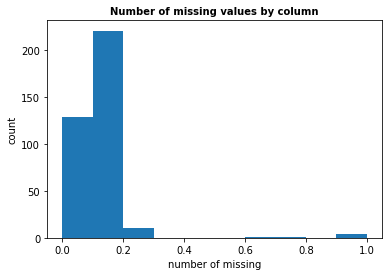

In [19]:
# Histogram of missing values per column
plt.hist(missing_by_col)

# Title
plt.title("Number of missing values by column", fontsize=10, fontweight="bold")

# x label
plt.xlabel("number of missing", fontsize=10)

# y label
plt.ylabel("count", fontsize=10)

plt.show()

In [20]:
#Distribution of missing values by rows:
row_nul_percent=azdias.isnull().sum(axis=1)

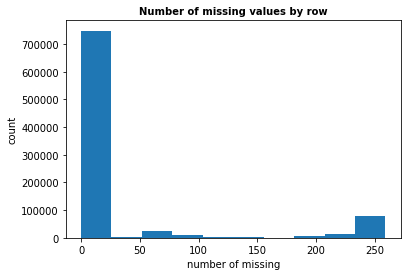

In [21]:
# Histogram of the percentage of missing values per row
plt.hist(row_nul_percent)

# Title
plt.title("Number of missing values by row", fontsize=10, fontweight="bold")

# x label
plt.xlabel("number of missing", fontsize=10)

# y label
plt.ylabel("count", fontsize=10)

plt.show()

In [22]:
def intersect_list(list1, list2):
    '''INPUT: list1 - first list
              list2 - second list
       OUTPUT: int_list - intersecting list'''
    int_list = list(set(list1) & set(list2))
    
    return int_list

In [23]:
def clean_data(df):
    '''INPUT: df - pandas dataframe that will be cleaned
       OUTPUT:  new_df - new pandas dataframe after cleaning'''
    
    #List to keep track of columns with problems
    prob_col_list = []
    
    #Fill missing values of working class variable
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].fillna(0)
    
    for column in df:
        #Remove columns with more than 15% missing values
        if df[column].isnull().sum() > (df.shape[0]*0.15):
            df.drop(columns = [column], inplace = True)
        else:
            try:
                #fill in missing values with mean of the corresponding working class the individual is in
                df[column] = df.groupby('CAMEO_DEUG_2015')[column].transform(lambda x: x.fillna(x.mean())).round(0)            
                df[column] = df[column].astype(str).str.replace('XX', '').astype(float).round(0).astype(int)
            except:
                try:
                    df[column] = df[column].astype(str).str.replace('X', '0').astype(float).round(0).astype(int)
                except:
                        try:
                            df[column] = df[column].fillna(0).astype(str).str.replace('XX', '0').astype(float).round(0).astype(int)
                        except:
                            prob_col_list.append(column)
                
    try:
        prob_col_list.append('CAMEO_DEU_2015')
    except:
        try: 
            prob_col_list.remove('CUSTOMER_GROUP')
            prob_col_list.remove('PRODUCT_GROUP')
        except:
            pass
    
    try:
        prob_col_list.remove('Cust_Ind')
    except:
        pass

    df_new = df[df.columns.difference(prob_col_list)]
    
    return df_new, prob_col_list

In [24]:
df_clean_agg, prob_col_list = clean_data(df_agg)

In [25]:
df_clean_cust, prob_cust_col_list = clean_data(Customers_subset)

In [26]:
#Only use columns where customer dataset possess high quality data
list_agg_col = list(df_clean_agg.columns)
list_cust_col = list(df_clean_cust.columns)
list_int_col = intersect_list(list_agg_col, list_cust_col)

In [27]:
df_clean_agg = df_clean_agg[list_int_col]

In [28]:
df_clean_agg.shape

(243000, 115)

In [29]:
df_clean_agg.head()

,D19_BANKEN_DIREKT,SEMIO_PFLICHT,D19_VOLLSORTIMENT,FINANZTYP,SEMIO_KAEM,GEBURTSJAHR,SEMIO_TRADV,LP_LEBENSPHASE_FEIN,SEMIO_REL,FINANZ_UNAUFFAELLIGER,...,FINANZ_MINIMALIST,NATIONALITAET_KZ,D19_TELKO_MOBILE,CJT_TYP_3,SEMIO_DOM,D19_REISEN,CJT_TYP_1,D19_BANKEN_GROSS,D19_BANKEN_ONLINE_DATUM,ANREDE_KZ
627384,0,6,0,1,2,0,5,1,7,3,...,1,1,0,1,1,0,5,0,10,1
846516,0,4,6,1,7,1965,2,16,3,3,...,3,1,5,3,7,0,3,6,10,2
327983,0,5,0,1,6,0,6,1,5,5,...,1,1,0,4,6,6,2,0,10,2
883265,0,3,0,1,7,1975,3,17,3,5,...,1,1,0,2,6,0,5,0,10,2
344676,0,1,6,6,3,1929,1,19,3,1,...,5,1,0,5,3,7,1,0,10,1


In [30]:
df_clean_agg.shape

(243000, 115)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [31]:
# Create labels to distinguish between general population and customer data
marca_individual = df_clean_agg['Cust_Ind']

# Remove the column 'Cust_Ind' to obtain the customer characteristics
caracteristicas_clientes = df_clean_agg.drop(columns=['Cust_Ind'])

In [32]:
#Scale the features

def features_array(df):
    '''INPUT: DataFrame numeric that will be scaled
       OUTPUT: array of scaled values'''
    
    # DataFrame Values
    x = df.values
    
    # Use StandardScaler to scale the values
    x_feature = StandardScaler().fit_transform(x)
    
    return x_feature

In [33]:
customer_scaled = features_array(caracteristicas_clientes)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [34]:
def matrix_correlation(df):
    '''INPUT: DataFrame numerical in which a correlation matrix will be created
       OUTPUT: A correlation matrix plot of the features with pastel colors and black borders'''
    
    # Create a figure and an axis for the graph
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Title
    plt.title('Correlation of Features')
    
    # Create the correlation matrix using a heatmap 
    cmap = sns.light_palette("seagreen")
    sns.heatmap(df.iloc[:, :15].corr(), linewidths=0.2, vmax=1, square=True, linecolor='black', annot=True, cmap=cmap)
    
    plt.show()

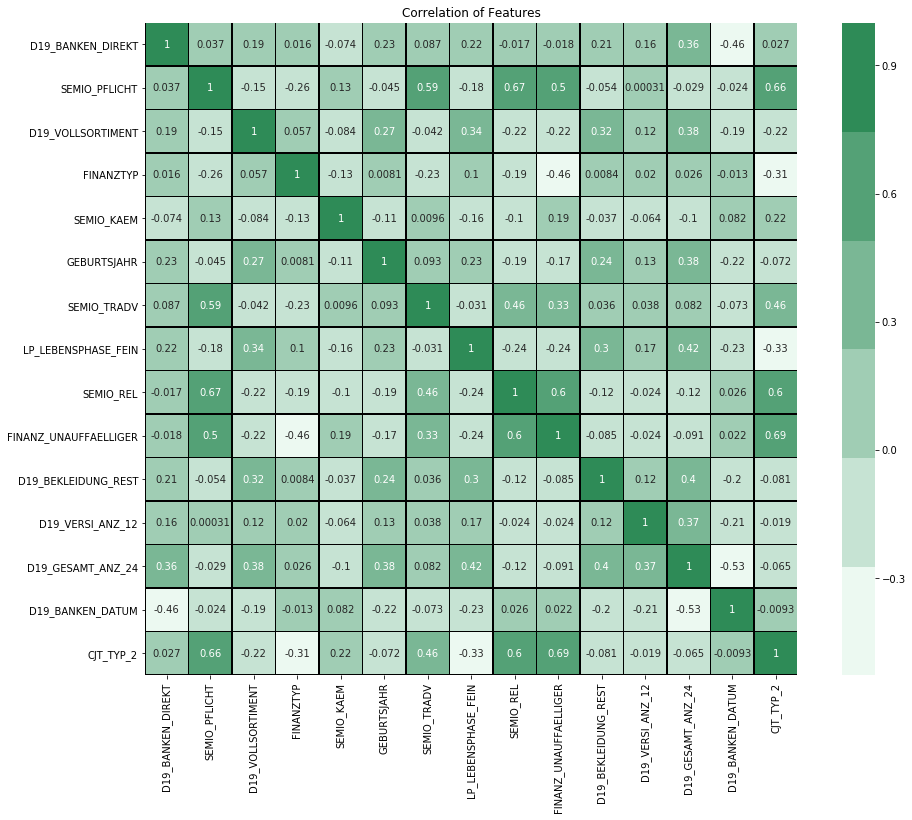

In [35]:
matrix_correlation(caracteristicas_clientes)

In [36]:
def eigenfix(num_array):
    '''INPUT: num_array - numerical matrix from which the eigenvalues and eigenvectors will be generated
       OUTPUT: fix_val - eigenvalue array
               fix_vec - eigenvalue array'''
    
    # Calculate the mean of the numerical matrix
    mean = np.mean(num_array, axis=0)
    
    # Calculate the covariance matrix of the numerical matrix
    covariance = np.cov(num_array, rowvar=False)
    
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    fix_val, fix_vec = np.linalg.eig(covariance)
    
    return fix_val, fix_vec

fix_val, fix_vec = eigenfix(customer_scaled)

In [37]:
def plot_variance(fix_val, fix_vec, plot=True):
    '''INPUT: eigenvalue array
              eigenvalue array
              boolean indicating whether to create a graph
       OUTPUT:tuple of values and ordered eigenvectors'''
    
    # Creating ordered tuples of eigenvalues and eigenvectors
    fix_tups = [(np.abs(fix_val[i]), fix_vec[:, i]) for i in range(len(fix_val))]
    fix_tups.sort(key=lambda x: x[0], reverse=True)
    
    # Calculate the proportion of variance explained and the accumulated variance
    tot_var = np.sum(fix_val)
    var_expl = [i / tot_var for i in sorted(fix_val, reverse=True)]
    cum_var = np.cumsum(var_expl)
    
    if plot:
        # Create graph of the most important main components
        plt.figure(figsize=(10, 5))
        plt.title('Most important Principal components')
        plt.xlabel('Principal Components')
        plt.ylabel('Proportion of variance explained')
        plt.bar(range(len(fix_val)), var_expl, color='b', label='Principal Component')
        plt.step(range(len(fix_val)), cum_var, label='Cumulative variance explained')
        plt.legend(loc='best')
        plt.show()
        
    print('Eigen Values in descending order: \n')
    for i in fix_tups:
        print(i[0])
        
    return fix_tups

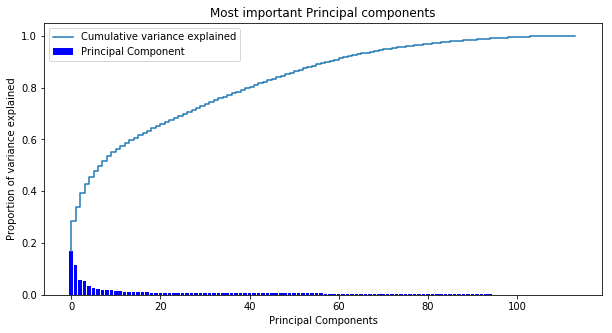

Eigen Values in descending order: 

19.115627586
13.169344305
6.58509720389
6.15311835258
3.93205595151
2.99338418118
2.63515684098
2.31250021371
2.19614790073
1.97707475075
1.69579113791
1.49508696354
1.40826150977
1.27465834617
1.19721066127
1.10388000474
1.07822375083
1.01637743885
0.993991548319
0.974241322232
0.963273819883
0.955545349371
0.941634260747
0.924949350779
0.909597349681
0.902785481193
0.88856589965
0.882584327636
0.861003871656
0.847583589127
0.845045627914
0.821134405707
0.811691770019
0.803217388938
0.794257542659
0.790229020574
0.754677902296
0.750104949108
0.741335573727
0.733854365477
0.728427776288
0.717153712922
0.709941527862
0.701920099418
0.686469067258
0.680552795638
0.675847373545
0.669623954079
0.662962826938
0.657148906191
0.648793305035
0.641042110339
0.635408167425
0.622986065567
0.608733811317
0.597431696443
0.573920535374
0.551248866488
0.54462905589
0.523704260321
0.518177495303
0.514167380646
0.499976756203
0.458440439448
0.433423210872
0.429672892

In [38]:
fix_tups = plot_variance(fix_val, fix_vec)

In [39]:
def matrix_new(df, fix_tups, frac_of_feat):
    '''INPUT: DataFrame which the array will be created.
              value tuples and eigenvectors
              fraction of characteristics to be used
       OUTPUT: projection matrix which will project the n-dimensional space to a lower dimensional subspace'''
    
    # Obtain the number of characteristics to be used according to the specified fraction.
    num_features = int(df.shape[1] * frac_of_feat)
    
    # Concatenate the selected eigenvectors into a projection matrix 
    matrix = np.hstack([fix_tups[i][1].reshape(-1, 1) for i in range(num_features)])
    
    return matrix

matrix = matrix_new(df_clean_agg, fix_tups, 0.1)

In [40]:
Y = customer_scaled.dot(matrix)

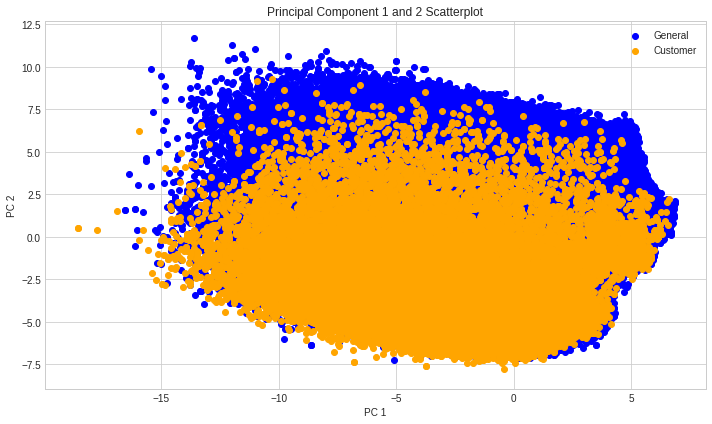

In [41]:
def diagrama_dispersion(Y, y_lab):
    '''INPUT: Projected scaled data values in the subspace
              Variable for labeling the scatter plot
       OUTPUT: Scatter plot of Y with "General Public" and "Customer" labels.'''

    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(10, 6))
        
        # Iterate on the labels ("General", "Customer") and the corresponding colors.
        for lab, col in zip(('General', 'Customer'), ('blue', 'orange')):
            # Create the scatter plot for each label
            plt.scatter(Y[y_lab==lab, 0],
                        Y[y_lab==lab, 1],
                        label=lab,
                        c=col)
        
        # Labels and Title
        plt.xlabel('PC 1')
        plt.ylabel('PC 2')
        plt.title('Principal Component 1 and 2 Scatterplot')
        
        # Display the legend and adjust the chart layout
        plt.legend(loc='best')
        plt.tight_layout()
        
        plt.show()

diagrama_dispersion(Y, marca_individual)

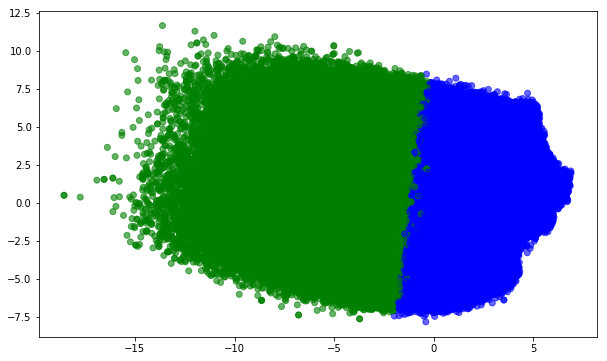

In [62]:
def diagrama_kmeans(Y, n_clust):
    '''INPUT: Projected values of scaled features
              number of clusters
       OUTPUT: K-means graph'''

    # Create a KMeans instance with the specified number of clusters
    kmeans = KMeans(n_clusters=n_clust)
    
    # Apply K-means and assign labels to projected data points
    x_clust = kmeans.fit_predict(Y)
    
    # Mapping of label colors to true colors
    LABEL_COLOR_MAP = {0: 'b', 1: 'g'}
    label_color = [LABEL_COLOR_MAP[i] for i in x_clust]

    # Plot scatter diagram
    plt.figure(figsize=(10, 6))
    plt.scatter(Y[:, 0], Y[:, 1], c=label_color, alpha=0.6)
    plt.show()
    
diagrama_kmeans(Y, 2)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [43]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [44]:
def Dataframe_Clean(df):
    '''INPUT: Dataframe to be cleared
       OUTPUT: Clean  Dataframe'''
    
    # Cleaning the data and obtaining clean_df and prob_list_train
    clean_df, prob_list_train = clean_data(df)
    
    # Obtaining Y_train and X_train from clean_df
    Y_train = clean_df['RESPONSE'].values
    X_train = clean_df.drop(columns=['RESPONSE'])
    
    return Y_train, X_train

In [45]:
Y_train, X_train = Dataframe_Clean(mailout_train)

In [46]:
#scale features
X_train_scaled = features_array(X_train)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


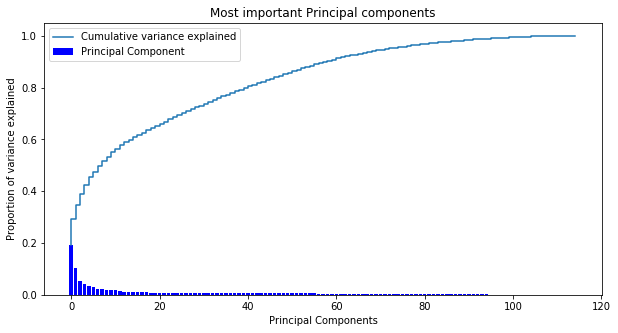

Eigen Values in descending order: 

21.9578723397
11.8662394312
6.08628315746
4.83439457561
4.08742514846
3.44069062349
2.44924458958
2.38083899189
2.22164722225
2.06407666525
1.99164019938
1.59999655062
1.41727673167
1.27119937977
1.15561998634
1.1183531388
1.0560340874
1.03595681893
1.01358794882
1.00108406295
0.995143862528
0.97333182661
0.966490163622
0.943727544641
0.930538496933
0.911773166187
0.887675284899
0.875698375574
0.860457010936
0.858641903618
0.838645270102
0.823464578827
0.812899708805
0.810753337151
0.793772434934
0.774723394757
0.767035125016
0.762953957959
0.758735170252
0.738007497459
0.728394834296
0.726177440528
0.719368797266
0.707745494227
0.694522699417
0.687643365689
0.680965017171
0.677319230689
0.664939463779
0.660241715566
0.654010558149
0.640369744744
0.628676249075
0.619542866803
0.600894965909
0.59206634958
0.569680019766
0.567954812471
0.529460668086
0.518061495275
0.506258217766
0.497621259277
0.482181577088
0.453909380536
0.411335438741
0.39898566387

In [47]:
fix_val_train, fix_vec_train = eigenfix(X_train_scaled)
fix_tups_train = plot_variance(fix_val_train, fix_vec_train)

In [48]:
matrix_train = matrix_new(mailout_train, fix_tups_train, 0.8)
matrix_train.shape

(115, 92)

In [49]:
# Project dataset to a lower dimension
X_project_train = X_train_scaled.dot(matrix_train)

In [50]:
# Intialize Logistic Regression and train data
l_regression = LogisticRegression()
l_regression.fit(X_project_train, Y_train);

In [51]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [52]:
clean_test, prob_list_test = clean_data(mailout_test)

In [53]:
#scale features
X_test_scaled = features_array(clean_test)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


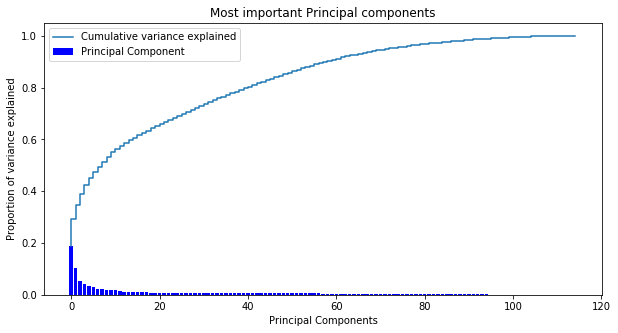

Eigen Values in descending order: 

21.8132586321
11.7870725074
6.12507374038
4.86540567696
4.06157575648
3.43926577956
2.46096304419
2.3841649409
2.22000484019
2.05228140354
2.01715590793
1.61409113982
1.41107921805
1.27650385477
1.15212579884
1.10624531193
1.06168305387
1.05233926466
1.00915907535
0.997305782588
0.994755589016
0.970202612911
0.961370247963
0.951513608311
0.930003440121
0.916128543736
0.883123466457
0.873864788575
0.868413685431
0.860732887815
0.855130965466
0.833870600558
0.824465757051
0.816292485753
0.78532925244
0.780250644626
0.768274407221
0.762908566963
0.759123958694
0.748888183281
0.736507903179
0.729274854891
0.721239787027
0.702275586349
0.698408262406
0.68313526854
0.676553290237
0.672105704893
0.665717458936
0.659018186674
0.650356951541
0.644028467584
0.641359449454
0.629290423337
0.602822665244
0.583925935892
0.58195319083
0.554287133005
0.533287058591
0.522128799819
0.520023221296
0.500212639082
0.485857122009
0.46063012566
0.413792706591
0.40628716671

In [54]:
#compute eigen values and vectors
fix_val_test, fix_vec_test = eigenfix(X_test_scaled)
fix_tups_test = plot_variance(fix_val_test, fix_vec_test)

In [55]:
#Create projection matrix
matrix_test = matrix_new(mailout_train, fix_tups_test, 0.8)
matrix_test.shape

(115, 92)

In [56]:
#Project dataset to a lower dimension
X_project_test = X_test_scaled.dot(matrix_test)

In [57]:
#Predict probabilities
Y_pred = l_regression.predict_proba(X_project_test)

In [58]:
Y_pred_df = pd.DataFrame(Y_pred)

In [59]:
Y_pred_cust_df = Y_pred_df[1]

In [60]:
list_Y_pred_cust = list(Y_pred_cust_df)